In [1]:
#imports
import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
sys.path.append('..')
import scipy as sp

from extremevalue.gpd import GEVMLE_ts

import pymc as pm
import pymc_experimental.distributions as pmx
import arviz as az

# from pymc import model_to_graphviz

In [2]:
df_hourly_max = pd.read_pickle('prcp_hourly_max.pkl')
df_X = pd.read_pickle('stations_xy.pkl')

In [3]:
params = {}

for station in df_hourly_max:

    GEV_hourly = GEVMLE_ts()
    GEV_hourly.fit(df_hourly_max[station].fillna(0.0))
    station_params = GEV_hourly.get_params()
    station_params['10y'] = GEV_hourly.return_level(10)
    station_params['100y'] = GEV_hourly.return_level(100)
    station_params['10yse'] = GEV_hourly.return_level_se(10).item()
    station_params['100yse'] = GEV_hourly.return_level_se(100).item()
    params[station] = station_params

df_GEV = pd.DataFrame(params).T
df_GEV

,mu,sigma,xi,10y,100y,10yse,100yse
BOS,0.743041,0.218308,0.082367,1.282793,1.964037,0.091115,0.318363
BDL,0.866210,0.326382,0.082323,1.673127,2.691466,0.140195,0.549130
JFK,0.984831,0.323643,0.141936,1.842901,3.085250,0.155777,0.609815
LGA,0.999008,0.340878,-0.017883,1.750878,2.504331,0.112338,0.321120
EWR,1.010923,0.313233,0.165943,1.865461,3.173123,0.161646,0.696984
PHL,1.087505,0.381774,-0.018358,1.929132,2.771611,0.123407,0.335926
ILG,1.023899,0.317822,0.159448,1.884261,3.181259,0.164271,0.735896


In [5]:
df_annual_max = df_hourly_max.groupby(lambda x:x.year).max()
df_annual_max.max(), df_annual_max.mean(), df_annual_max.std()

(station
 BOS    2.03
 BDL    2.38
 JFK    2.88
 LGA    2.44
 EWR    3.24
 PHL    2.84
 ILG    2.69
 dtype: float64,
 station
 BOS    0.888302
 BDL    1.083019
 JFK    1.223019
 LGA    1.190943
 EWR    1.249245
 PHL    1.299623
 ILG    1.261698
 dtype: float64,
 station
 BOS    0.313968
 BDL    0.450126
 JFK    0.504406
 LGA    0.432854
 EWR    0.493102
 PHL    0.488034
 ILG    0.473037
 dtype: float64)

In [6]:
station = 'JFK'

ts_hourly_max = df_hourly_max[station]
ts_annual_max = df_annual_max[station]

GEV_hourly = GEVMLE_ts()
GEV_hourly.fit(ts_hourly_max)
GEV_hourly.get_params()

{'mu': 0.984831125432392,
 'sigma': 0.3236428951095842,
 'xi': 0.14193555821043535}

In [7]:
GEV_hourly.return_level(100)

3.085250101547203

In [8]:
def gev_returnlevel(rp, μ, σ, ξ):
    p = 1.0 / rp
    return μ - (σ / ξ) * (1 - np.power(-np.log(1.0 - p), -ξ))

In [9]:
# data =ts_annual_max.values

# # return_periods = GEV_hourly._return_periods(n=50)
# return_periods = np.logspace(0.01,2, num=100)
# p = 1/return_periods

# with pm.Model() as model:
#     # Priors
#     μ = pm.Normal("μ", mu=1.0, sigma=0.5)
#     σ = pm.HalfNormal("σ", sigma=0.5)
#     ξ = pm.math.tanh(pm.Normal("ξ", mu=0, sigma=0.15))

#     # Estimation
#     gev = pmx.GenExtreme("gev", mu=μ, sigma=σ, xi=ξ, observed=data)
#     # Return level
#     z_p = pm.Deterministic("z_p", μ - σ / ξ * (1 - (-np.log(1 - p)) ** (-ξ)))
#     # z_p = pm.Deterministic("z_p", gev_returnlevel(return_periods, μ, σ, ξ))
#     gev_returnlevel

In [10]:
GEV_hourly.return_level(100), GEV_hourly.return_level_se(100)

(3.085250101547203, array(0.60981525))

In [11]:
GEV_hourly.get_params()

{'mu': 0.984831125432392,
 'sigma': 0.3236428951095842,
 'xi': 0.14193555821043535}

In [12]:
import pytensor.tensor as pt

#upgrade to halversine distance
#https://en.wikipedia.org/wiki/Haversine_formula

class Matern32Chordal(pm.gp.cov.Stationary):
    def __init__(self, input_dims, ls, r=6378.137, active_dims=None):
        if input_dims != 2:
            raise ValueError("Chordal distance is only defined on 2 dimensions")
        super().__init__(input_dims, ls=ls, active_dims=active_dims)
        self.r = r

    def lonlat2xyz(self, lonlat):
        lonlat = np.deg2rad(lonlat)
        return self.r * pt.stack(
            [
                pt.cos(lonlat[..., 0]) * pt.cos(lonlat[..., 1]),
                pt.sin(lonlat[..., 0]) * pt.cos(lonlat[..., 1]),
                pt.sin(lonlat[..., 1]),
            ],
            axis=-1,
        )

    def chordal_dist(self, X, Xs=None):
        if Xs is None:
            Xs = X
        X, Xs = pt.broadcast_arrays(
            self.lonlat2xyz(X[..., :, None, :]), self.lonlat2xyz(Xs[..., None, :, :])
        )
        return pt.sqrt(pt.sum(((X - Xs) / self.ls) ** 2, axis=-1) + 1e-12)

    def full(self, X, Xs=None):
        X, Xs = self._slice(X, Xs)
        r = self.chordal_dist(X, Xs)
        return (1.0 + np.sqrt(3.0) * r) * pt.exp(-np.sqrt(3.0) * r)

In [13]:
f = 


SyntaxError: invalid syntax (2391194814.py, line 1)

In [19]:
sample_cols = df_annual_max.columns
# sample_cols = ['JFK','LGA','EWR']

df_X_y = df_annual_max[sample_cols].stack().to_frame('PRCP').join(df_X)
X_ = df_X_y[['X','Y']].to_numpy()
y_ = df_X_y['PRCP'].to_numpy()
X_.shape, y_.shape

df_X_y_ = df_X_y.reset_index()
station_idx, stations = df_X_y_['station'].factorize(sort=True)
X = df_X.loc[stations][['X','Y']].to_numpy()

In [24]:
coords = {
    "cov_params": ["mu","sigma"],
    "location" : ["x","y"],
    "station" : stations,
    "obs" : df_X_y_.index,
    
}

with pm.Model(coords=coords) as gp_model:
    pt_station_idx = pm.ConstantData("station_idx", station_idx, dims="obs")
    pt_X = pm.ConstantData("station_loc", X, dims=("station","location"))

    ℓ = pm.InverseGamma("ℓ", mu = 200.0, sigma = 50.0)
    η = pm.Gamma("η", mu=0.1, sigma=0.2, dims = "cov_params")

    cov_μ = η[0]**2 * pm.gp.cov.Exponential(input_dim = 2, ls = ℓ)
    gp_μ = pm.gp.Latent(cov_func=cov_μ)
    μ_group = pm.Normal("μ_group", mu=1.0, sigma=2.0)
    μ = pm.Deterministic("μ", μ_group + gp_μ.prior("μ_gp", X=pt_X, dims="station"))

    cov_σ_log = η[1]**2 * pm.gp.cov.Exponential(input_dim = 2, ls = ℓ)
    gp_σ_log = pm.gp.Latent(cov_func=cov_σ_log)
    σ_log = gp_σ_log.prior("σ_log", X=pt_X, dims="station")
    σ_log_group = pm.Normal("σ_log_group", mu=-1.0, sigma=5.0)
    σ = pm.Deterministic("σ", pm.math.exp(σ_log_group + σ_log))

    ξ = pm.math.tanh(pm.Normal("ξ", mu=0, sigma=0.15))

    μ_vec = μ[pt_station_idx]
    σ_vec = σ[pt_station_idx]

    gev = pmx.GenExtreme("gev", mu=μ_vec, sigma=σ_vec, xi=ξ, observed=y_, dims="obs")

    gp_trace = pm.sample(1000, 
        tune = 1000, 
        chains = 2, 
        cores = 2, 
        target_accept = 0.98,
        nuts_sampler = "numpyro"
        )

# pm.model_to_graphviz(gp_model)

/Users/mosselveen/dev/extremeweather/.conda/lib/python3.10/site-packages/pymc/sampling/mcmc.py:273: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:04.480849
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:19.594176
Transforming variables...
Transformation time =  0:00:00.311980


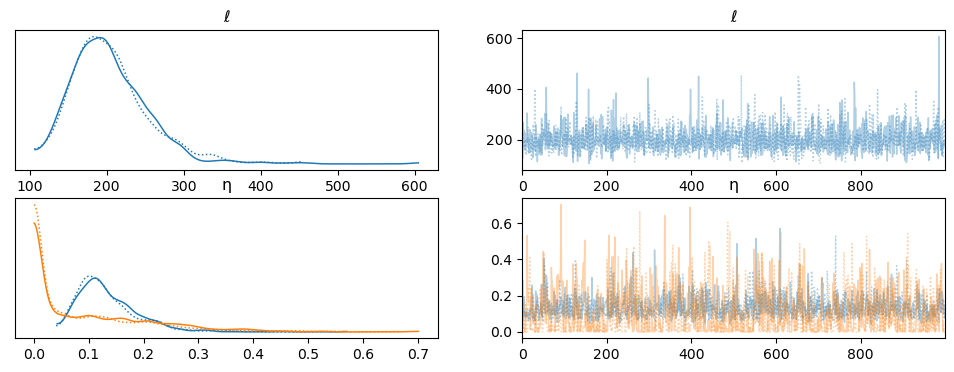

In [25]:
az.plot_trace(gp_trace, var_names=["ℓ", "η"]);

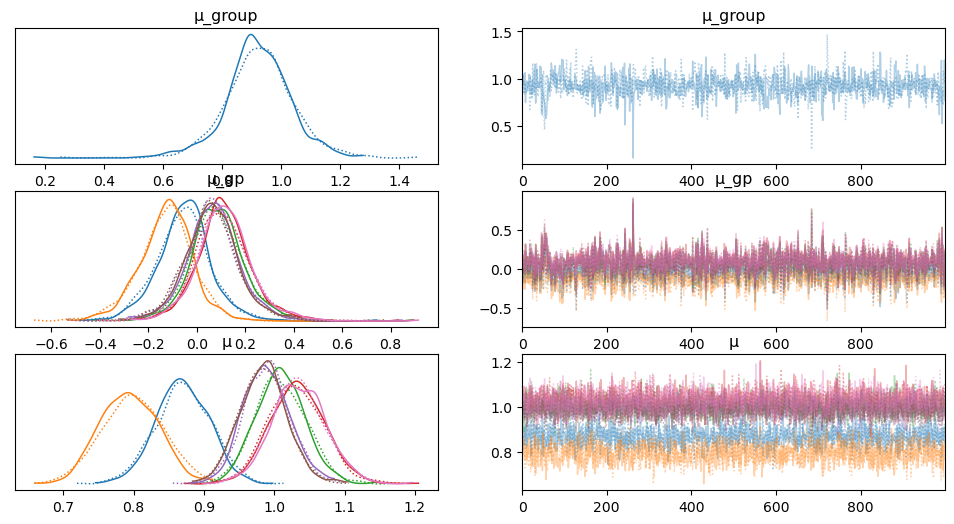

In [26]:
az.plot_trace(gp_trace, var_names=["μ_group","μ_gp","μ"]);

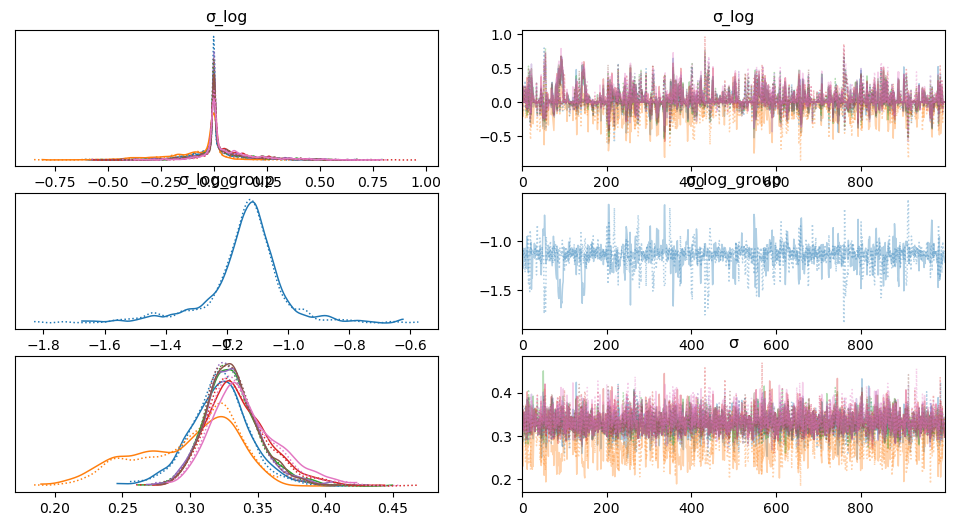

In [27]:
az.plot_trace(gp_trace, var_names=["σ_log","σ_log_group","σ"]);

In [28]:
az.summary(gp_trace,var_names=["ℓ", "η"],hdi_prob= 0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
ℓ,203.759,50.557,117.37,297.820,1.187,0.893,2092.0,1357.0,1.00
η[mu],0.134,0.058,0.05,0.239,0.002,0.001,941.0,1316.0,1.00
η[sigma],0.102,0.115,0.00,0.326,0.005,0.004,393.0,701.0,1.01


In [29]:
az.summary(gp_trace,var_names=["μ", "σ", "ξ"],hdi_prob= 0.95).sort_values('r_hat')

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
μ[0],0.870,0.039,0.789,0.941,0.001,0.001,2422.0,1822.0,1.00
μ[1],0.796,0.042,0.716,0.878,0.001,0.001,1374.0,1176.0,1.00
μ[2],1.009,0.036,0.936,1.076,0.001,0.001,1875.0,1482.0,1.00
μ[3],1.032,0.040,0.953,1.108,0.001,0.001,2319.0,1611.0,1.00
μ[4],0.989,0.033,0.922,1.053,0.001,0.000,2333.0,1822.0,1.00
μ[5],0.984,0.034,0.920,1.050,0.001,0.000,2584.0,1667.0,1.00
μ[6],1.034,0.039,0.957,1.111,0.001,0.001,2040.0,1694.0,1.00
σ[0],0.322,0.023,0.276,0.368,0.000,0.000,2038.0,1807.0,1.00
σ[2],0.331,0.020,0.292,0.373,0.000,0.000,2160.0,1708.0,1.00
σ[3],0.335,0.024,0.292,0.384,0.001,0.000,1756.0,1668.0,1.00


In [30]:
X_sample = df_X.loc[sample_cols][['X','Y']].to_numpy()
# X_sample = df_X[['X','Y']].to_numpy()

pred_vars = ["mu_pred1", "sigma_log_pred1", "xi_pred1","z_p_101","z_p_1001"]
pred_vars = ["mu_pred3", "mu_pred_gp3", "sigma_log_pred3","sigma_pred3", "ξ"]
jitter = 1e-6

with gp_model:
    mu_pred = pm.Deterministic(pred_vars[0], μ_group + gp_μ.conditional(pred_vars[1], Xnew=X_sample, jitter=jitter))
    sigma_log_pred = gp_σ_log.conditional(pred_vars[2], Xnew=X_sample, jitter=jitter)
    sigma_pred = pm.Deterministic(pred_vars[3], pm.math.exp(σ_log_group+sigma_log_pred))

    posterior_pred = pm.sample_posterior_predictive(gp_trace, var_names=pred_vars)

Sampling: [mu_pred_gp3, sigma_log_pred3, ξ]
INFO:pymc.sampling.forward:Sampling: [mu_pred_gp3, sigma_log_pred3, ξ]


In [31]:
pred_xi = az.extract(posterior_pred.posterior_predictive, var_names="ξ")
pred_mu = az.extract(posterior_pred.posterior_predictive, var_names="mu_pred3")
pred_sigma = az.extract(posterior_pred.posterior_predictive, var_names="sigma_pred3")

In [32]:
gev_returnlevel(10.0,pred_mu.to_numpy(),pred_sigma.to_numpy(),pred_xi.to_numpy()).mean(axis=1)
# gev_returnlevel(100.0,pred_mu.to_numpy(),pred_sigma.to_numpy(),pred_xi.to_numpy()).mean(axis=1)

array([1.47682515, 1.60464231, 1.74276215, 1.73885442, 1.76336686,
       1.80884656, 1.79654123])

In [33]:
gev_returnlevel(100.0,pred_mu.to_numpy(),pred_sigma.to_numpy(),pred_xi.to_numpy()).mean(axis=1)

array([2.27530833, 2.46489542, 2.6259744 , 2.62330487, 2.64717261,
       2.7164382 , 2.69241216])

In [34]:
df_GEV

,mu,sigma,xi,10y,100y,10yse,100yse
BOS,0.743041,0.218308,0.082367,1.282793,1.964037,0.091115,0.318363
BDL,0.866210,0.326382,0.082323,1.673127,2.691466,0.140195,0.549130
JFK,0.984831,0.323643,0.141936,1.842901,3.085250,0.155777,0.609815
LGA,0.999008,0.340878,-0.017883,1.750878,2.504331,0.112338,0.321120
EWR,1.010923,0.313233,0.165943,1.865461,3.173123,0.161646,0.696984
PHL,1.087505,0.381774,-0.018358,1.929132,2.771611,0.123407,0.335926
ILG,1.023899,0.317822,0.159448,1.884261,3.181259,0.164271,0.735896
